### **DRIVE MOUNT**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


***Augmenting the Dataset to 2000***

In [ ]:
# Augmentation
import os
import random
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- Configuration ---
# Set the path to your dataset folder in Google Drive
base_dataset_path = '/content/drive/MyDrive/Thesis/dataset' # <-- IMPORTANT: Check this path is correct

# Define the folders for each class
class_folders = {
    'acnes': 'acnes',
    'hyperpigmentation': 'hyperpigmentation',
    'Nail_psoriasis': 'Nail_psoriasis',
    'SJS-TEN': 'SJS-TEN',
    'Vitiligo': 'Vitiligo' # <-- Double-check this name matches your folder exactly
}

# The target number of images per class
target_image_count = 2000

# --- Augmentation Setup ---
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# --- Main Loop ---
for class_name, folder_name in class_folders.items():
    folder_path = os.path.join(base_dataset_path, folder_name)

    # --- ⭐️ ERROR FIX: Check if the folder exists ---
    if not os.path.isdir(folder_path):
        print(f"🚨 ERROR: Directory not found for class '{class_name}': {folder_path}. Skipping.")
        continue

    # Get the list of all images in the folder
    images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    num_images = len(images)

    print(f"\nProcessing '{class_name}': Found {num_images} images.")

    # --- Logic to Increase, Decrease, or Skip ---
    if num_images < target_image_count:
        # --- AUGMENTATION (INCREASE) LOGIC ---
        num_to_generate = target_image_count - num_images
        print(f"Augmenting '{class_name}': Generating {num_to_generate} new images...")

        # Select random images from the folder to augment
        images_to_augment = random.choices(images, k=num_to_generate)

        for image_name in images_to_augment:
            image_path = os.path.join(folder_path, image_name)
            try:
                img = Image.open(image_path).convert('RGB')
                img = img.resize((224, 224))
                x = np.array(img)
                x = x.reshape((1,) + x.shape)

                # Generate one augmented image
                for batch in datagen.flow(x, batch_size=1):
                    augmented_image = Image.fromarray(batch[0].astype('uint8'))
                    new_image_name = f"aug_{random.randint(10000, 99999)}_{image_name}"
                    augmented_image.save(os.path.join(folder_path, new_image_name))
                    break # Stop after one is generated
            except Exception as e:
                print(f"Could not process image {image_name}. Error: {e}")

    elif num_images > target_image_count:
        # --- ⭐️ NEW: DECREASE LOGIC ---
        num_to_delete = num_images - target_image_count
        print(f"Decreasing '{class_name}': Randomly deleting {num_to_delete} images...")

        # Randomly select images to delete
        images_to_delete = random.sample(images, num_to_delete)

        for image_name in images_to_delete:
            file_to_delete_path = os.path.join(folder_path, image_name)
            try:
                os.remove(file_to_delete_path)
            except Exception as e:
                print(f"Could not delete image {image_name}. Error: {e}")

    else: # num_images == target_image_count
        print(f"'{class_name}' already has {target_image_count} images. No action needed.")


print("\nProcessing complete! ✅")


Processing 'acnes': Found 2000 images.
'acnes' already has 2000 images. No action needed.

Processing 'hyperpigmentation': Found 2000 images.
'hyperpigmentation' already has 2000 images. No action needed.

Processing 'Nail_psoriasis': Found 2000 images.
'Nail_psoriasis' already has 2000 images. No action needed.

Processing 'SJS-TEN': Found 2000 images.
'SJS-TEN' already has 2000 images. No action needed.

Processing 'Vitiligo': Found 2000 images.
'Vitiligo' already has 2000 images. No action needed.

Processing complete! ✅


**Data Splitting to 70,15,15**

In [ ]:
import os
import random
import shutil

# --- Configuration ---
# Path to your balanced dataset (where each class has 2000 images)
source_dataset_path = '/content/drive/MyDrive/Thesis/dataset' # <-- IMPORTANT: Path to your processed dataset

# Path where the new split dataset will be created
output_dataset_path = '/content/drive/MyDrive/Thesis/new_dataset'

# Define the split ratios
# 70% for training, 15% for validation, 15% for testing
split_ratios = (0.7, 0.15, 0.15)

# --- Main Splitting Logic ---
print("Starting dataset split...")

# Create the main output directories (train, validation, test)
if os.path.exists(output_dataset_path):
    shutil.rmtree(output_dataset_path) # Remove old directory to ensure a clean split
    print(f"Removed existing directory at: {output_dataset_path}")

train_dir = os.path.join(output_dataset_path, 'train')
validation_dir = os.path.join(output_dataset_path, 'validation')
test_dir = os.path.join(output_dataset_path, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get the list of class folders from the source directory
class_names = [d for d in os.listdir(source_dataset_path) if os.path.isdir(os.path.join(source_dataset_path, d))]

# Loop through each class folder
for class_name in class_names:
    print(f"\nProcessing class: {class_name}")

    # Create class-specific subdirectories in train, validation, and test folders
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Get all image file names for the current class
    source_class_dir = os.path.join(source_dataset_path, class_name)
    all_files = [f for f in os.listdir(source_class_dir) if os.path.isfile(os.path.join(source_class_dir, f))]

    # Shuffle the files randomly for an unbiased split
    random.shuffle(all_files)

    # Calculate split indices
    total_files = len(all_files)
    train_end = int(total_files * split_ratios[0])
    validation_end = train_end + int(total_files * split_ratios[1])

    # Slice the list of files into the three sets
    train_files = all_files[:train_end]
    validation_files = all_files[train_end:validation_end]
    test_files = all_files[validation_end:]

    # --- Function to copy files ---
    def copy_files(files, source_dir, dest_dir):
        for f in files:
            shutil.copy(os.path.join(source_dir, f), os.path.join(dest_dir, f))

    # Copy files to their new destination
    copy_files(train_files, source_class_dir, os.path.join(train_dir, class_name))
    copy_files(validation_files, source_class_dir, os.path.join(validation_dir, class_name))
    copy_files(test_files, source_class_dir, os.path.join(test_dir, class_name))

    print(f"  - Training set:   {len(train_files)} images")
    print(f"  - Validation set: {len(validation_files)} images")
    print(f"  - Testing set:    {len(test_files)} images")

print("\nDataset splitting complete! ✅")

Starting dataset split...
Removed existing directory at: /content/drive/MyDrive/Thesis/new_dataset

Processing class: hyperpigmentation
  - Training set:   1400 images
  - Validation set: 300 images
  - Testing set:    300 images

Processing class: Nail_psoriasis
  - Training set:   1400 images
  - Validation set: 300 images
  - Testing set:    300 images

Processing class: SJS-TEN
  - Training set:   1400 images
  - Validation set: 300 images
  - Testing set:    300 images

Processing class: Vitiligo
  - Training set:   1400 images
  - Validation set: 300 images
  - Testing set:    300 images

Processing class: acnes
  - Training set:   1400 images
  - Validation set: 300 images
  - Testing set:    300 images

Dataset splitting complete! ✅


**VGG16 Model**

Found 7000 images belonging to 5 classes.
Found 1500 images belonging to 5 classes.
Found 1500 images belonging to 5 classes.
Found 5 classes.

--- Starting Initial Training (Feature Extraction) ---
Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 534s 5s/step - accuracy: 0.5844 - loss: 1.7964 - val_accuracy: 0.8493 - val_loss: 0.4733
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.8280 - loss: 0.4915 - val_accuracy: 0.8840 - val_loss: 0.3868
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.8439 - loss: 0.4333 - val_accuracy: 0.9233 - val_loss: 0.2701
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.8807 - loss: 0.3259 - val_accuracy: 0.9260 - val_loss: 0.2391
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.8920 - loss: 0.2960 - val_accuracy: 0.9247 - val_loss: 0.2499
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.9021 - loss: 0.2637 - val_accuracy: 0.9327 - val_loss: 0.2038
Epoch 7/10
110/110 ━━━━━━━━

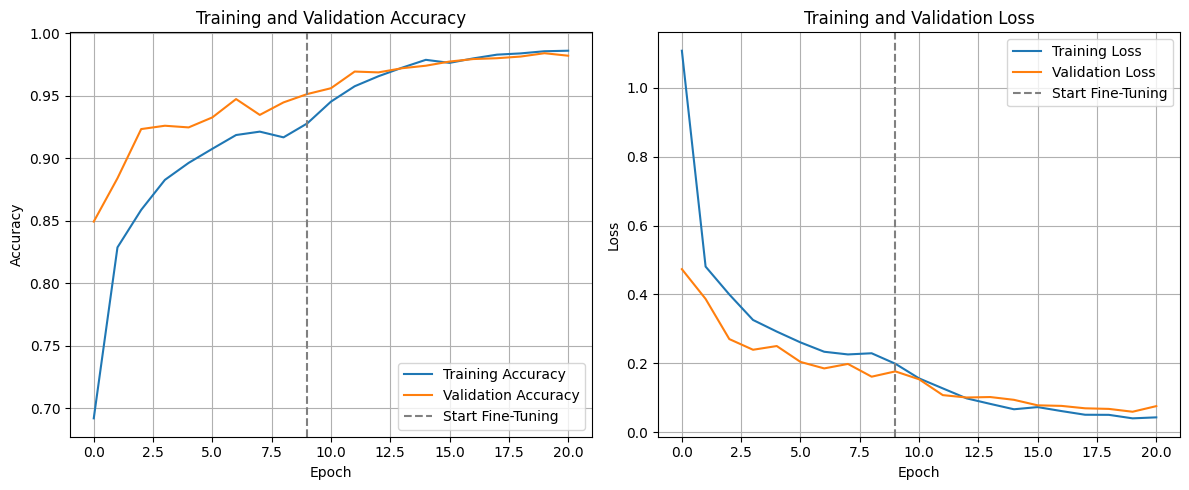

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os

# --- 1. Configuration and Setup ---

# Define paths
# IMPORTANT: Update these paths to match your directory structure
base_dir = '/content/drive/MyDrive/Thesis/Split_Dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Model parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 64 # Increased from 32 to reduce steps per epoch. This will make training faster.
INITIAL_EPOCHS = 10
FINE_TUNE_EPOCHS = 10
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS

# --- 2. Data Loading and Preprocessing ---

# Create ImageDataGenerators with VGG16-specific preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

# Create data generators from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False
)

num_classes = train_generator.num_classes
print(f"Found {num_classes} classes.")

# --- 3. Model Building (Transfer Learning) ---

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# --- 4. Compile the Model (Feature Extraction Phase) ---
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("\n--- Starting Initial Training (Feature Extraction) ---")
history = model.fit(
    train_generator,
    epochs=INITIAL_EPOCHS,
    validation_data=validation_generator
)

# --- 5. Fine-Tuning Phase ---
print("\n--- Starting Fine-Tuning ---")
base_model.trainable = True
fine_tune_at = 15
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(
    train_generator,
    epochs=TOTAL_EPOCHS,
    initial_epoch=history.epoch[-1],
    validation_data=validation_generator
)

# --- 6. Final Evaluation on the Test Set ---
print("\n--- Evaluating Model on Test Data ---")
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# --- 7. Plotting Training History ---
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.axvline(INITIAL_EPOCHS - 1, color='gray', linestyle='--', label='Start Fine-Tuning')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(INITIAL_EPOCHS - 1, color='gray', linestyle='--', label='Start Fine-Tuning')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**Confusion Matrix**

24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 364ms/step

## Classification Report ##

                   precision    recall  f1-score   support

   Nail_psoriasis       0.98      1.00      0.99       300
          SJS-TEN       0.95      0.98      0.97       300
         Vitiligo       0.97      0.96      0.96       300
            acnes       0.99      0.97      0.98       300
hyperpigmentation       1.00      0.98      0.99       300

         accuracy                           0.98      1500
        macro avg       0.98      0.98      0.98      1500
     weighted avg       0.98      0.98      0.98      1500


## Confusion Matrix ##



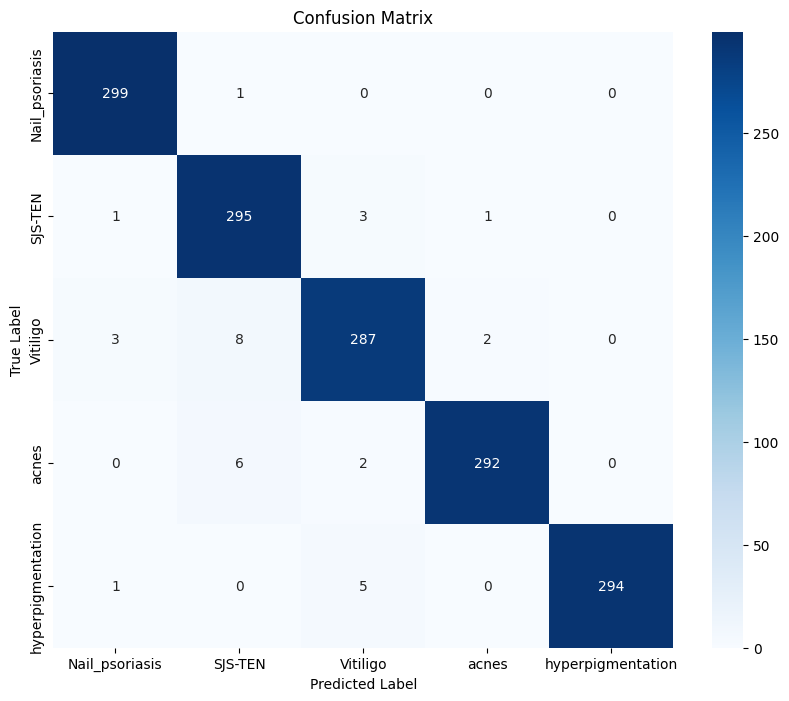

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. Get Predictions and True Labels ---

# Ensure the test generator is not shuffling the data
test_generator.reset()

# Predict the output for the test set
# The model.predict() function will return the probability for each class
y_pred_probs = model.predict(
    test_generator,
    # FIX: Convert the result to an integer
    steps=int(np.ceil(test_generator.samples / test_generator.batch_size))
)

# Convert the probabilities to a single predicted class index
# np.argmax finds the index of the highest probability
y_pred = np.argmax(y_pred_probs, axis=1)

# Get the true labels from the generator
y_true = test_generator.classes

# Get the class names from the generator
class_names = list(test_generator.class_indices.keys())


# --- 2. Generate Classification Report ---
# This report includes precision, recall, and f1-score for each class

print("\n## Classification Report ##\n")
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


# --- 3. Plot Confusion Matrix ---

print("\n## Confusion Matrix ##\n")

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

**ResNet50**

Found 7000 images belonging to 5 classes.
Found 1500 images belonging to 5 classes.
Found 1500 images belonging to 5 classes.
Found 5 classes.

--- Starting Initial Training (Feature Extraction) ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.6703 - loss: 1.2777 - val_accuracy: 0.9080 - val_loss: 0.2834
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.8868 - loss: 0.3229 - val_accuracy: 0.9307 - val_loss: 0.2180
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.9052 - loss: 0.2529 - val_accuracy: 0.9427 - val_loss: 0.1845
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.9240 - loss: 0.2103 - val_accuracy: 0.9367 - val_loss: 0.1764
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.9358 - loss: 0.1797 - val_accuracy: 0.9467 - val_loss: 0.1476
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.9344 - loss: 0.1710 - val_accuracy: 0.9527 - val_loss: 0.1393
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.9442 - loss: 0.1484 - val_accuracy: 0.9540 - val_loss: 0.1357
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.9483 - loss: 0.1368 - val_accu

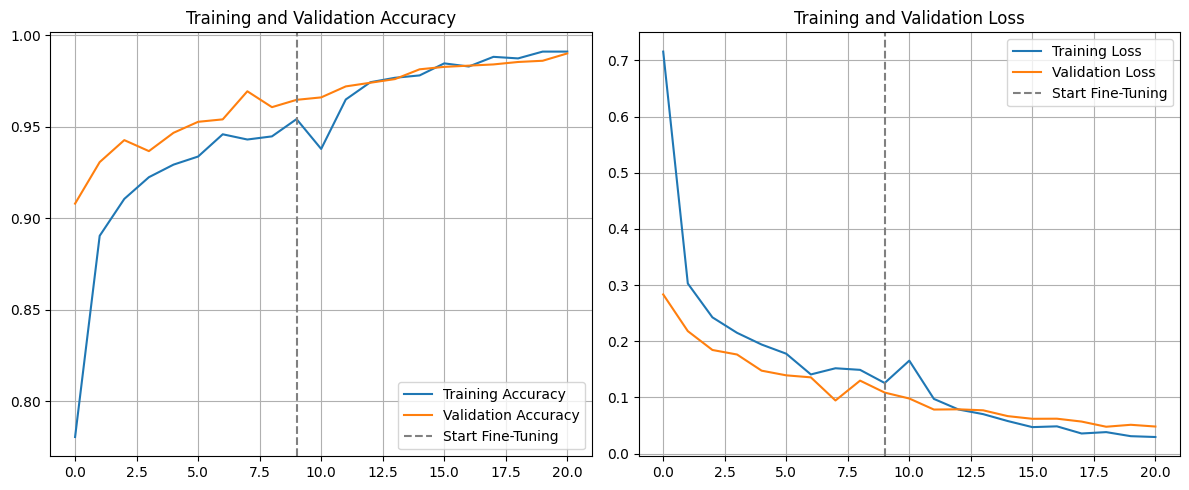

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os

# --- 1. SETUP FOR SPEED: MIXED PRECISION ---
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# --- 2. Configuration and Setup ---
# Define paths to your split dataset
base_dir = '/content/drive/MyDrive/Thesis/Split_Dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Model parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 64 # Increased batch size for faster training
INITIAL_EPOCHS = 10
FINE_TUNE_EPOCHS = 10
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS

# --- 3. Data Loading and Preprocessing ---
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
validation_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='sparse')
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='sparse')
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='sparse', shuffle=False)

num_classes = train_generator.num_classes
print(f"Found {num_classes} classes.")

# --- 4. Model Building ---
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax', dtype='float32')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# --- 5. Compile and Train (Feature Extraction) ---
optimizer = tf.keras.mixed_precision.LossScaleOptimizer(Adam(learning_rate=0.001))
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("\n--- Starting Initial Training (Feature Extraction) ---")
# FIX: Removed 'workers' and 'use_multiprocessing' arguments
history = model.fit(
    train_generator,
    epochs=INITIAL_EPOCHS,
    validation_data=validation_generator
)

# --- 6. Fine-Tuning Phase ---
print("\n--- Starting Fine-Tuning ---")
base_model.trainable = True
fine_tune_at = 143
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

optimizer_fine = tf.keras.mixed_precision.LossScaleOptimizer(Adam(learning_rate=1e-5))
model.compile(optimizer=optimizer_fine,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# FIX: Removed 'workers' and 'use_multiprocessing' arguments
history_fine = model.fit(
    train_generator,
    epochs=TOTAL_EPOCHS,
    initial_epoch=history.epoch[-1],
    validation_data=validation_generator
)

# --- 7. Final Evaluation ---
print("\n--- Evaluating Model on Test Data ---")
# FIX: Removed 'workers' and 'use_multiprocessing' arguments
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# --- 8. Plotting History ---
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.axvline(INITIAL_EPOCHS - 1, color='gray', linestyle='--', label='Start Fine-Tuning')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(INITIAL_EPOCHS - 1, color='gray', linestyle='--', label='Start Fine-Tuning')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Confusion Matrix**

24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 473ms/step

## Classification Report ##

                   precision    recall  f1-score   support

   Nail_psoriasis       0.99      0.99      0.99       300
          SJS-TEN       1.00      0.96      0.98       300
         Vitiligo       0.94      0.99      0.96       300
            acnes       1.00      1.00      1.00       300
hyperpigmentation       1.00      0.97      0.98       300

         accuracy                           0.98      1500
        macro avg       0.98      0.98      0.98      1500
     weighted avg       0.98      0.98      0.98      1500


## Confusion Matrix ##



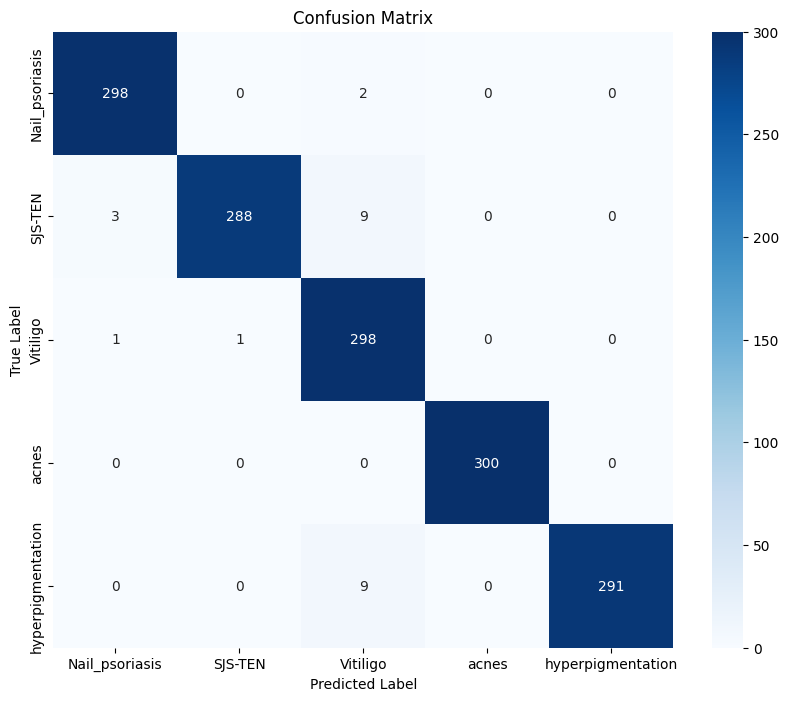

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. Get Predictions and True Labels ---

# Ensure the test generator is not shuffling the data
test_generator.reset()

# Predict the output for the test set
# The model.predict() function will return the probability for each class
y_pred_probs = model.predict(
    test_generator,
    # FIX: Convert the result to an integer
    steps=int(np.ceil(test_generator.samples / test_generator.batch_size))
)

# Convert the probabilities to a single predicted class index
# np.argmax finds the index of the highest probability
y_pred = np.argmax(y_pred_probs, axis=1)

# Get the true labels from the generator
y_true = test_generator.classes

# Get the class names from the generator
class_names = list(test_generator.class_indices.keys())


# --- 2. Generate Classification Report ---
# This report includes precision, recall, and f1-score for each class

print("\n## Classification Report ##\n")
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


# --- 3. Plot Confusion Matrix ---

print("\n## Confusion Matrix ##\n")

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

**Copying the dataset from the google drive to local storage**

In [ ]:
import os
import shutil
from tqdm import tqdm

# Path to your dataset on Google Drive
drive_dataset_path = "/content/drive/MyDrive/Thesis/Split_Dataset"
# Path where you want to copy locally (Colab's fast storage)
local_dataset_path = "/content/dataset/Split_Dataset"

# Remove any old copy if exists
if os.path.exists(local_dataset_path):
    shutil.rmtree(local_dataset_path)

# Copy dataset from Drive to Colab local storage
print("Copying dataset from Drive to local storage...")
shutil.copytree(drive_dataset_path, local_dataset_path)

print("✅ Dataset copied to:", local_dataset_path)


Copying dataset from Drive to local storage...
✅ Dataset copied to: /content/dataset/Split_Dataset


**Multi-Resolution Ensemble Network (MREN)**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, InceptionV3, EfficientNetB0
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os
import time
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. SETUP & CONFIGURATION ---
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Set paths to the local copy of the dataset
base_dir = '/content/dataset/Split_Dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Model parameters
IMG_SIZE_224 = 224
IMG_SIZE_299 = 299
BATCH_SIZE = 64
INITIAL_EPOCHS = 8
FINE_TUNE_EPOCHS = 12
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS

# --- 2. OPTIMIZED Data Pipeline with tf.data.Dataset ---
train_datagen_224 = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)
train_datagen_299 = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)
val_datagen_224 = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)
val_datagen_299 = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

train_flow_224 = train_datagen_224.flow_from_directory(
    train_dir, target_size=(IMG_SIZE_224, IMG_SIZE_224), batch_size=BATCH_SIZE, class_mode='sparse', shuffle=True)
train_flow_299 = train_datagen_299.flow_from_directory(
    train_dir, target_size=(IMG_SIZE_299, IMG_SIZE_299), batch_size=BATCH_SIZE, class_mode='sparse', shuffle=True)
val_flow_224 = val_datagen_224.flow_from_directory(
    validation_dir, target_size=(IMG_SIZE_224, IMG_SIZE_224), batch_size=BATCH_SIZE, class_mode='sparse', shuffle=False)
val_flow_299 = val_datagen_299.flow_from_directory(
    validation_dir, target_size=(IMG_SIZE_299, IMG_SIZE_299), batch_size=BATCH_SIZE, class_mode='sparse', shuffle=False)

# --- ⭐️ DATASET VERIFICATION ---
# Create a temporary generator for the test set to verify its contents
test_datagen_verify = ImageDataGenerator()
test_flow_verify = test_datagen_verify.flow_from_directory(
    test_dir, target_size=(IMG_SIZE_224, IMG_SIZE_224), batch_size=BATCH_SIZE, class_mode='sparse')

print("\n--------------------")
print("Dataset Verification:")
print(f"Training Set:   Found {train_flow_224.samples} images belonging to {train_flow_224.num_classes} classes.")
print(f"Validation Set: Found {val_flow_224.samples} images belonging to {val_flow_224.num_classes} classes.")
print(f"Testing Set:    Found {test_flow_verify.samples} images belonging to {test_flow_verify.num_classes} classes.")
print("--------------------\n")

# Continue with the tf.data.Dataset pipeline for training
def multi_input_generator(gen224, gen299):
    while True:
        X1, y1 = next(gen224)
        X2, y2 = next(gen299)
        yield (X1, X2), y1

output_signature = (
    (tf.TensorSpec(shape=(None, IMG_SIZE_224, IMG_SIZE_224, 3), dtype=tf.float16),
     tf.TensorSpec(shape=(None, IMG_SIZE_299, IMG_SIZE_299, 3), dtype=tf.float16)),
    tf.TensorSpec(shape=(None,), dtype=tf.float32)
)

train_dataset = tf.data.Dataset.from_generator(
    lambda: multi_input_generator(train_flow_224, train_flow_299),
    output_signature=output_signature).prefetch(tf.data.AUTOTUNE)
validation_dataset = tf.data.Dataset.from_generator(
    lambda: multi_input_generator(val_flow_224, val_flow_299),
    output_signature=output_signature).prefetch(tf.data.AUTOTUNE)

num_classes = train_flow_224.num_classes

# --- 3. Building the MREN Model ---
input_224 = Input(shape=(IMG_SIZE_224, IMG_SIZE_224, 3), name='input_224')
input_299 = Input(shape=(IMG_SIZE_299, IMG_SIZE_299, 3), name='input_299')

resnet_base = ResNet50(weights='imagenet', include_top=False, input_tensor=input_224, name='resnet50')
resnet_base.trainable = False
effnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_224, name='efficientnetb0')
effnet_base.trainable = False
inception_base = InceptionV3(weights='imagenet', include_top=False, input_tensor=input_299, name='inception_v3')
inception_base.trainable = False

out_resnet = GlobalAveragePooling2D(name='gap_resnet')(resnet_base.output)
out_effnet = GlobalAveragePooling2D(name='gap_effnet')(effnet_base.output)
out_inception = GlobalAveragePooling2D(name='gap_inception')(inception_base.output)

concat_features = Concatenate(name='concat_features')([out_resnet, out_effnet, out_inception])
meta_dense_1 = Dense(512, activation='relu', name='meta_dense_1')(concat_features)
meta_dropout_1 = Dropout(0.5, name='meta_dropout_1')(meta_dense_1)
final_predictions = Dense(num_classes, activation='softmax', dtype='float32', name='final_predictions')(meta_dropout_1)

mren_model = Model(inputs=[input_224, input_299], outputs=final_predictions, name="MREN_Model")
base_models = [resnet_base, effnet_base, inception_base]

# --- 4. Compile and Train (Feature Extraction) ---
optimizer = tf.keras.mixed_precision.LossScaleOptimizer(Adam(learning_rate=0.001))
mren_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("\n--- Starting Initial Training (Training the Meta-Learner) ---")
history = mren_model.fit(
    train_dataset,
    steps_per_epoch=len(train_flow_224),
    epochs=INITIAL_EPOCHS,
    validation_data=validation_dataset,
    validation_steps=len(val_flow_224)
)

# --- 5. FULL FINE-TUNING PHASE ---
print("\n--- Starting Fine-Tuning (All Three Models) ---")
for base_model in base_models:
    base_model.trainable = True
    if 'resnet' in base_model.name: fine_tune_at = 143
    elif 'efficientnet' in base_model.name: fine_tune_at = -30
    else: fine_tune_at = 249

    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

optimizer_fine = tf.keras.mixed_precision.LossScaleOptimizer(Adam(learning_rate=1e-5))
mren_model.compile(optimizer=optimizer_fine, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_fine = mren_model.fit(
    train_dataset,
    steps_per_epoch=len(train_flow_224),
    epochs=TOTAL_EPOCHS,
    initial_epoch=history.epoch[-1],
    validation_data=validation_dataset,
    validation_steps=len(val_flow_224)
)

# --- 6. Plotting Training History ---
print("\n--- Plotting Training and Validation History ---")
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.axvline(INITIAL_EPOCHS - 1, color='gray', linestyle='--', label='Start Fine-Tuning')
plt.title('MREN Model Accuracy')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(INITIAL_EPOCHS - 1, color='gray', linestyle='--', label='Start Fine-Tuning')
plt.title('MREN Model Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Found 7000 images belonging to 5 classes.
Found 7000 images belonging to 5 classes.
Found 1500 images belonging to 5 classes.
Found 1500 images belonging to 5 classes.
Found 1500 images belonging to 5 classes.

--------------------
Dataset Verification:
Training Set:   Found 7000 images belonging to 5 classes.
Validation Set: Found 1500 images belonging to 5 classes.
Testing Set:    Found 1500 images belonging to 5 classes.
--------------------

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

--- Starting Initial Training (Training the Meta-Learner) ---
Epoch 1/8
 41/110 ━━━━━━━━━━━━━━━━━━━━ 1:37:43 85s/step - accuracy: 0.5282 - loss: 1.9889

Found 1500 images belonging to 5 classes.
Found 1500 images belonging to 5 classes.

--- Generating predictions on the test set... ---
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 518ms/step

Keras Class Mapping: {'Nail_psoriasis': 0, 'SJS-TEN': 1, 'Vitiligo': 2, 'acnes': 3, 'hyperpigmentation': 4}
Correctly Ordered Labels for Report: ['Nail_psoriasis', 'SJS-TEN', 'Vitiligo', 'acnes', 'hyperpigmentation']

## Classification Report ##

                   precision    recall  f1-score   support

   Nail_psoriasis       1.00      0.99      1.00       300
          SJS-TEN       1.00      0.99      0.99       300
         Vitiligo       0.99      0.99      0.99       300
            acnes       0.99      1.00      1.00       300
hyperpigmentation       0.99      1.00      1.00       300

         accuracy                           0.99      1500
        macro avg       0.99      0.99      0.99      1500
     weighted avg       0.99      0.99      0.99      1500


## Confusion Matrix ##



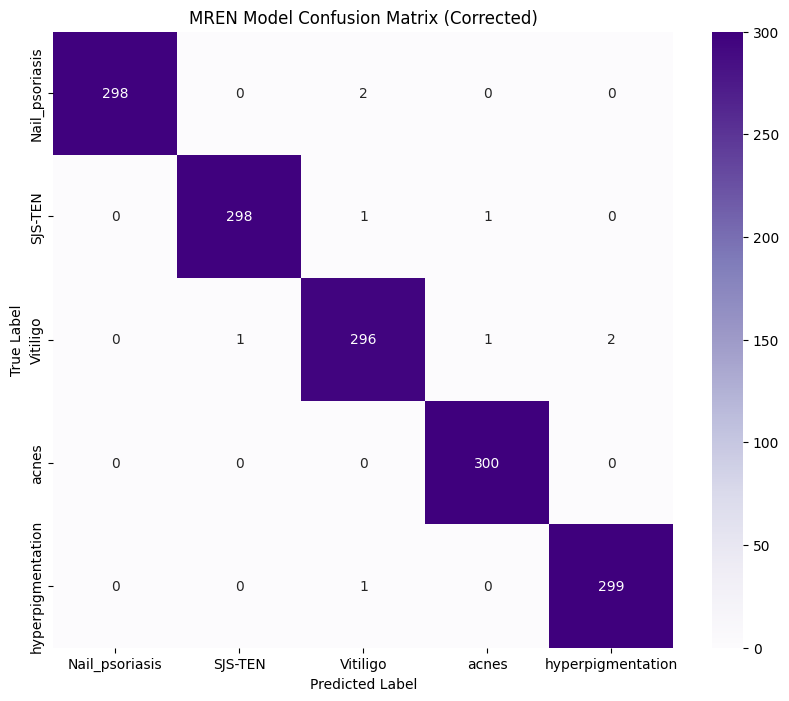

In [ ]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import os

# --- 1. Configuration and Test Data Pipeline Setup ---
# This section re-creates the data pipeline for the test set.
# NOTE: Ensure these variables match your training script.

# Set paths to the local copy of the dataset
base_dir = '/content/dataset/Split_Dataset'
test_dir = os.path.join(base_dir, 'test')

# Model parameters
IMG_SIZE_224 = 224
IMG_SIZE_299 = 299
BATCH_SIZE = 64

# Create two separate data flows for the two required image sizes
# shuffle=False is critical for evaluation
test_datagen_224 = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)
test_datagen_299 = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

test_flow_224 = test_datagen_224.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE_224, IMG_SIZE_224),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False)

test_flow_299 = test_datagen_299.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE_299, IMG_SIZE_299),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False)

# Custom Python generator that yields the multi-input data
def multi_input_generator(gen224, gen299):
    while True:
        X1, y1 = next(gen224)
        X2, y2 = next(gen299)
        yield (X1, X2), y1

# Define the data signature for TensorFlow
output_signature = (
    (tf.TensorSpec(shape=(None, IMG_SIZE_224, IMG_SIZE_224, 3), dtype=tf.float16),
     tf.TensorSpec(shape=(None, IMG_SIZE_299, IMG_SIZE_299, 3), dtype=tf.float16)),
    tf.TensorSpec(shape=(None,), dtype=tf.float32)
)

# Convert the Python generator into an optimized tf.data.Dataset
test_dataset = tf.data.Dataset.from_generator(
    lambda: multi_input_generator(test_flow_224, test_flow_299),
    output_signature=output_signature
).prefetch(tf.data.AUTOTUNE)

# --- 2. Get Model Predictions ---
print("\n--- Generating predictions on the test set... ---")

# Calculate the number of steps needed to cover the entire test set
test_steps = len(test_flow_224)

# Get predictions from the trained MREN model
y_pred_probs = mren_model.predict(test_dataset, steps=test_steps)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get the true labels
y_true = test_flow_224.classes

# Ensure prediction array has the correct length
y_pred = y_pred[:len(y_true)]

# --- 3. FIX: Create Correctly Ordered Class Labels ---
# This step prevents the cyclical error in the confusion matrix

class_indices = test_flow_224.class_indices
# Sort the dictionary by its integer value (0, 1, 2...)
sorted_indices = sorted(class_indices.items(), key=lambda item: item[1])
# Create a new list of names in the correct order
correctly_ordered_class_names = [item[0] for item in sorted_indices]

print("\nKeras Class Mapping:", class_indices)
print("Correctly Ordered Labels for Report:", correctly_ordered_class_names)

# --- 4. Display Evaluation Metrics ---

# Generate and print the classification report
print("\n## Classification Report ##\n")
print(classification_report(y_true, y_pred, target_names=correctly_ordered_class_names))

# Generate and plot the confusion matrix
print("\n## Confusion Matrix ##\n")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=correctly_ordered_class_names,
            yticklabels=correctly_ordered_class_names)
plt.title('MREN Model Confusion Matrix (Corrected)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [1]:
!pip install opencv-python

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2 # OpenCV for image processing
import os

# --- 1. The Grad-CAM Algorithm ---

def get_grad_cam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Creates a Grad-CAM heatmap.
    """
    # Create a model that maps the input image to the activations
    # of the last conv layer as well as the final predictions
    grad_model = tf.keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Use GradientTape to compute the gradient of the top predicted class
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization, we'll normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def superimpose_grad_cam(img, heatmap, alpha=0.4):
    """
    Superimposes the heatmap on the original image.
    """
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = plt.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

    return superimposed_img


# --- 2. Prepare an Image and Model for Explanation ---

# ⭐️ IMPORTANT: Specify the path to an image from your test set
IMAGE_PATH = '/content/split_dataset/test/acnes/acnes (1).jpg' # <-- CHANGE THIS

# Create a directory to save the results
os.makedirs("xai_results", exist_ok=True)

# Load the original image for visualization later
original_img = cv2.imread(IMAGE_PATH)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# Preprocess the image for the 224x224 input
img_224 = tf.keras.utils.load_img(IMAGE_PATH, target_size=(224, 224))
img_array_224 = tf.keras.utils.img_to_array(img_224)
img_array_224 = np.expand_dims(img_array_224, axis=0) # Add batch dimension
preprocessed_224 = tf.keras.applications.resnet.preprocess_input(img_array_224.copy())

# Preprocess the image for the 299x299 input
img_299 = tf.keras.utils.load_img(IMAGE_PATH, target_size=(299, 299))
img_array_299 = tf.keras.utils.img_to_array(img_299)
img_array_299 = np.expand_dims(img_array_299, axis=0) # Add batch dimension
preprocessed_299 = tf.keras.applications.inception_v3.preprocess_input(img_array_299.copy())

# Get the class names in the correct order
class_names = correctly_ordered_class_names # Assumes this is available from your previous evaluation script

# Make a prediction with the MREN model
preds = mren_model.predict([preprocessed_224, preprocessed_299])
top_pred_index = np.argmax(preds[0])
print(f"MREN model prediction: {class_names[top_pred_index]} with {preds[0][top_pred_index]:.2f} confidence.")


# --- 3. Generate and Save Heatmaps for Each Branch ---

# You need to find the name of the last convolutional layer for each base model.
# You can find these by printing `base_model.summary()` for each.
# Common layer names are provided here:
last_conv_layer_names = {
    "ResNet50": "conv5_block3_out",
    "EfficientNetB0": "top_conv",
    "InceptionV3": "mixed10"
}

# Generate a heatmap for each base model
for model_name, layer_name in last_conv_layer_names.items():
    print(f"\n--- Generating Grad-CAM for {model_name} ---")

    # Select the appropriate preprocessed image array
    if model_name == "InceptionV3":
        input_array = [preprocessed_224, preprocessed_299] # MREN needs both inputs
    else:
        input_array = [preprocessed_224, preprocessed_299] # MREN needs both inputs

    # Generate the heatmap
    heatmap = get_grad_cam_heatmap(input_array, mren_model, layer_name, pred_index=top_pred_index)

    # Superimpose the heatmap on the original image
    superimposed_image = superimpose_grad_cam(original_img, heatmap)

    # Save the final image
    save_path = os.path.join("xai_results", f"grad_cam_{model_name}.png")
    superimposed_image.save(save_path)

    # Display the result
    plt.figure(figsize=(8, 8))
    plt.imshow(superimposed_image)
    plt.title(f"Grad-CAM for {model_name}", fontsize=16)
    plt.axis("off")
    plt.show()

print("\n--- XAI analysis complete. Images saved in 'xai_results' directory. ---")

error: OpenCV(4.12.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'
